In [1]:
import plotly.graph_objects as go
import copy as cp
from pprint import pprint
from gurobipy import *
from random import *
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import time
from itertools import groupby,chain
import itertools
import pandas as pd
from pandas import *
import networkx as nx
import random
from random import shuffle
from itertools import chain
import string
import json
from dataclasses import dataclass
import uuid
import bisect
from datetime import datetime

In [2]:
delta = 0.05
update_interval = 2
rcl_parameter = 0.3
llambda = 0.7

In [3]:
graph_top_left = [x for x in chain(range(0,11), range(27,38),range(54,65),range(81,92),range(108,119),range(135,146),range(162,173),range(189,200),range(216,227),range(243,254),range(270,281),range(297,308),range(324,335),range(351,362))]
graph_top_right = [x for x in chain(range(378,389),range(405,416),range(432,443),range(459,470),range(486,497),range(513,524),range(540,551),range(567,578),range(594,605),range(621,632),range(648,658),range(675,686),range(702,712))]
graph_center = [x for x in chain(range(200,208), range(227,234),range(253,261),range(281,289),range(308,316),range(335,343),range(362,370),range(389,397),range(416,424),range(443,451),range(470,478),range(497,505),range(524,532))]
graph_left  = [x for x in chain(range(11,19), range(38,46),range(65,73),range(92,100),range(119,127),range(146,154),range(173,181))]
graph_right = [x for x in chain(range(551,559), range(578,586),range(605,613),range(632,640),range(659,667),range(686,694),range(713,721))]
graph_bottom_left = [x for x in chain(range(19,27), range(46,54),range(73,81),range(100,108),range(127,135),range(154,162),range(181,189),range(208,216),range(235,243),range(262,270),range(289,297),range(316,324),range(343,351),range(370,378))]
graph_bottom_right = [x for x in chain(range(397,405),range(424,432),range(451,459),range(478,486),range(505,513),range(532,540),range(559,567),range(586,594),range(613,621),range(640,648),range(667,675),range(694,702),range(721,728))]

In [4]:
N = 5
G1 = nx.grid_2d_graph(N,N)

labels=dict(((i,j),i + (N-1-j)*N) for i, j in G1.nodes())
nx.relabel_nodes(G1,labels,False) #False=relabel the nodes in place
inds=labels.keys()
vals=labels.values()
inds=[(N-j-1,N-i-1) for i,j in inds]

#Create the dictionary of positions for the grid
grid_pos=dict(zip(vals,inds)) #Format: {node ID:(i,j)}

random.seed(511566511)
nodes = list(G1.nodes)
edges = list(G1.edges)

# top_left_remove = random.sample(graph_top_left,20)
# top_right_remove = random.sample(graph_top_right,10)
# bottom_left_remove = random.sample(graph_bottom_left,25)
# bottom_right_remove = random.sample(graph_bottom_right,35)
# center_remove = random.sample(graph_center,50)
# left_remove =random.sample(graph_left,50)
# right_remove = random.sample(graph_right,50)

# while nx.is_connected(G1) == True:
#     while len(G1) > 20:
    


#         if len(list(nx.isolates(G1)))>0:
#             G1.remove_nodes_from(list(nx.isolates(G1)))
#         if nx.is_connected(G1) == False:
#             G1 = G1_C
#         else:
#             G1_C=G1.copy()
#         if len(G1) <= 20:
#                 break


#Create the dictionary of positions for the grid
grid_pos=dict(zip(vals,inds)) #Format: {node ID:(i,j)}


# G1.remove_node(11)
# G1.remove_node(8)
# G1.remove_node(18)


#Clean the dictionaries in accordance with how we changed the original graph
for i in list(grid_pos):
    if i not in G1.nodes:
        grid_pos.pop(i)
        
coords = []
for i in inds:
    for key, value in grid_pos.items():
        if i == value:
            coords.append(i)

In [5]:
def get_furthest_nodes(G):
    sp_length = {} # dict containing shortest path distances for each pair of nodes
    diameter = None # will contain the graphs diameter (length of longest shortest path)
    furthest_node_list = [] # will contain list of tuple of nodes with shortest path equal to diameter
    
    for node in G.nodes:
        # Get the shortest path from node to all other nodes
        sp_length[node] = nx.single_source_dijkstra_path_length(G,node, weight = 'distance')
        longest_path = max(sp_length[node].values()) # get length of furthest node from node
        
        # Update diameter when necessary (on first iteration and when we find a longer one)
        if diameter == None:
            diameter = longest_path # set the first diameter
            
        # update the list of tuples of furthest nodes if we have a best diameter
        if longest_path >= diameter:
            diameter = longest_path
            
            # a list of tuples containing
            # the current node and the nodes furthest from it
            node_longest_paths = [(node,other_node)
                                      for other_node in sp_length[node].keys()
                                      if sp_length[node][other_node] == longest_path]
            if longest_path > diameter:
                # This is better than the previous diameter
                # so replace the list of tuples of diameter nodes with this nodes
                # tuple of furthest nodes
                furthest_node_list = node_longest_paths
            else: # this is equal to the current diameter
                # add this nodes tuple of furthest nodes to the current list    
                furthest_node_list = furthest_node_list + node_longest_paths
                
    # return the diameter,
        # all pairs of nodes with shortest path length equal to the diameter
        # the dict of all-node shortest paths
    return({'diameter':diameter,
            'furthest_node_list':furthest_node_list,
            'node_shortest_path_dicts':sp_length})

#Define a function to find the union of two lists
def Union(lst1,lst2):
    final_list = list(set(lst1) | set(lst2))
    return final_list

In [6]:
def plus_plus(ds, k):
    """
    Create cluster centroids using the k-means++ algorithm.
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    Inspiration from here: https://stackoverflow.com/questions/5466323/how-could-one-implement-the-k-means-algorithm
    """
#     np.random.seed(random_state)
    centroids = [random.choice(ds)]

    for _ in range(1, k):
        dist_sq = np.array([min([np.inner(c-x,c-x) for c in centroids]) for x in ds])
        probs = dist_sq/dist_sq.sum()
        cumulative_probs = probs.cumsum()
        r = np.random.rand()
        
        for j, p in enumerate(cumulative_probs):
            if r < p:
                i = j
                break
        
        centroids.append(ds[i])

    return np.array(centroids)

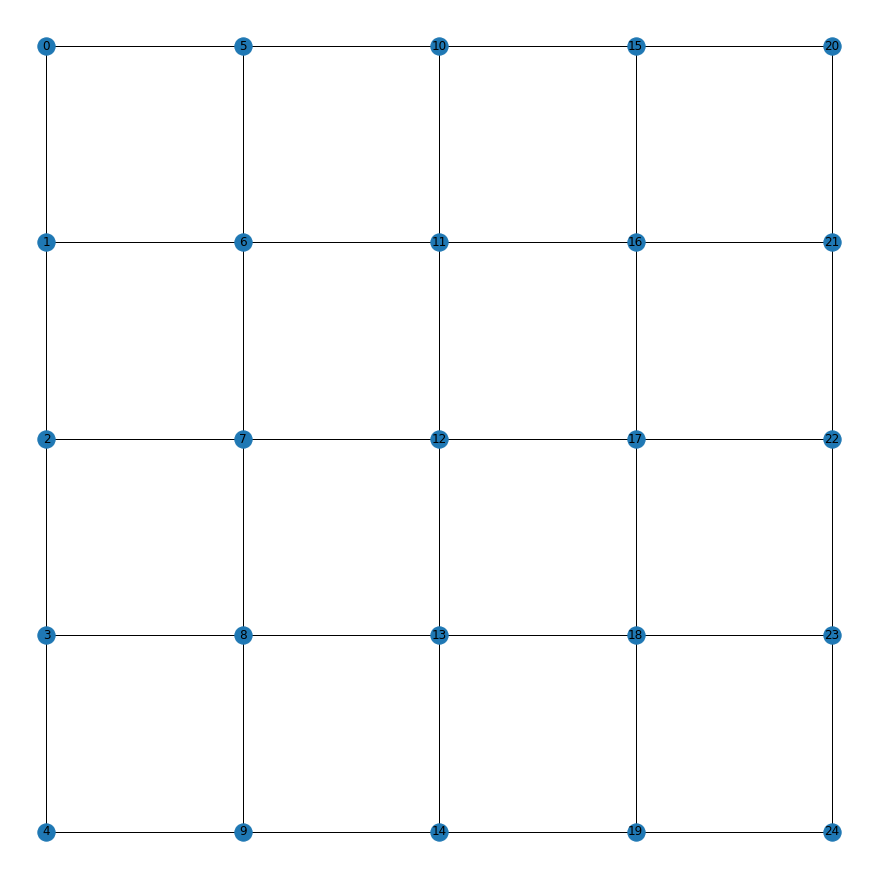

In [19]:
plt.figure(3,figsize=(12,12))
nx.draw(G1, pos=grid_pos,with_labels = True)
plt.show()

In [112]:
def construction_grasp(delta, rcl_parameter,llambda,graph_input):
    #Choosing centers

#     locations = np.array(coords)

#     centroids = plus_plus(locations, 2)

#     centroids = centroids.tolist()

#     centroids_tuple = []
#     for i in centroids:
#         centroids_tuple.append(tuple((i)))

#     centers_depots = []
#     for i in centroids_tuple:
#         for key, value in grid_pos.items():
#             if i == value:
#                 centers_depots.append(key)

    centers_depots = [0,20,24]
                
    #Initialize randomized activities
    combinations = list(itertools.combinations(centers_depots, 3))



    #Calculate the average for each activity
    adjacent = {}
    for i in graph_input.nodes():
            adjacent[i] = []
    for e in graph_input.edges():
        adjacent[e[0]].append(e)
        adjacent[e[1]].append(e)

    #Define adjacent nodes for each node

    adjacent_nodes = {}
    nodes_new = {}
    for i in adjacent:
        adjacent_nodes[i] = []
        for e in range(len(adjacent[i])):
            adjacent_nodes[i].append(adjacent[i][e][0])
            adjacent_nodes[i].append(adjacent[i][e][1])
    for i in adjacent_nodes:
        nodes_new[i] = list(set(adjacent_nodes[i]))
    adjacent_nodes = {k:[vi for vi in v if k != vi] for k,v in nodes_new.items()}



    random.seed(2021)
    demand= {}
    for v in graph_input.nodes:
        demand[v] = 1

    random.seed(2021)
    workload= {}
    for v in graph_input.nodes:
        workload[v] = 1

    random.seed(2021)
    n_customers= {}
    for v in graph_input.nodes:
        n_customers[v] = 1

#     random.seed(2021)
#     for v in centers_depots:
#         demand[v] = 400
#         workload[v] = 100
#         n_customers[v] = 20
#         for i in adjacent_nodes[v]:
#             demand[i] = random.randint(370,400)
#             workload[i] = random.randint(90,100)
#             n_customers[i] = random.randint(15,20)

#     random.seed(2021)
    distance= {}
    for e in graph_input.edges:
        distance[e] = 1


    nx.set_node_attributes(graph_input, values = n_customers, name = "n_customers")
    nx.set_node_attributes(graph_input, values = demand, name = "demand")
    nx.set_node_attributes(graph_input, values = workload, name = "workload")
    nx.set_edge_attributes(graph_input, values = distance, name = "distance")
    
    
    shortest_paths_dict = get_furthest_nodes(graph_input)['node_shortest_path_dicts']
    graph_diameter = get_furthest_nodes(graph_input)['diameter']

    total_workload = 0 
    for v in graph_input.nodes:
        total_workload = total_workload + graph_input.nodes[v]['workload']
    average_workload = total_workload/len(centers_depots)

    total_customers = 0 
    for v in graph_input.nodes:
        total_customers = total_customers + graph_input.nodes[v]['n_customers']
    average_customers = total_customers/len(centers_depots)

    total_demand = 0 
    for v in graph_input.nodes:
        total_demand = total_demand + graph_input.nodes[v]['demand']
    average_demand = total_demand/len(centers_depots)



    selected_nodes = {}
    near_nodes = {}
    for k in centers_depots:
        selected_nodes[k] = []
        selected_nodes[k] = nx.ego_graph(graph_input,k, radius = 1, center=False, undirected=True, distance='distance')
        near_nodes[k] = list(selected_nodes[k].nodes())

#     for v in near_nodes:
#         print(list(any(v in val for val in near_nodes.values())))

    #Find the percentage of selected nodes from the graph
    num_nodes = 0
    for i in near_nodes:
        num_nodes = num_nodes+len(near_nodes[i])

    percentage_nodes = 1-(num_nodes/len(nodes))

    construction_time = time.time()

    #Create the initial districts by assigning the nodes in the neighborhood to depots
    district_customers = {}
    district_workload = {}
    district_demand = {}
    unassigned = set(graph_input.nodes) - set(centers_depots)
    neighborhood = {}
    district = {}
    district[0] = list(unassigned)
    district[24] = []
    district[20] = []
    rcl = {}
    i = 0
#     while 0.7*len(graph_input.nodes) <= len(unassigned):
#         print("In while loop")
#         district[0] = unassigned

    for k in centers_depots:
        district_customers[k]= 0
        district_workload[k] = 0
        district_demand[k] = 0
#             neighborhood[k] = []
#             neighborhood[k] = near_nodes[k]
#             unassigned = unassigned-set(near_nodes[k])-set(centers_depots)
#             district[k] = []
#             district[k] = Union(district[k], neighborhood[k])
#Find the total of each activity for each district
        for w in district[k]:
            district_customers[k] = district_customers[k] + graph_input.nodes[w]['n_customers']
            district_workload[k] = district_workload[k] + graph_input.nodes[w]['workload']
            district_demand[k] = district_demand[k] + graph_input.nodes[w]['demand']
        print(district)
        print(len(unassigned))
                
            
    


#     local_infeasible = 0

#     for i in range(len(centers_depots)):
#         local_infeasible = local_infeasible + ((1/average_customers)*max(district_customers[centers_depots[i]]-(1+delta)*average_customers,(1-delta)*average_customers-district_customers[centers_depots[i]],0))+\
#             ((1/average_demand)*max(district_demand[centers_depots[i]]-(1+delta)*average_demand,(1-delta)*average_demand-district_demand[centers_depots[i]],0))+\
#                 ((1/average_workload)*max(district_workload[centers_depots[i]]-(1+delta)*average_workload,(1-delta)*average_workload-district_workload[centers_depots[i]],0))

#     #Select a larger neighborhood for the depots
#     larger_selected_nodes = {}
#     larger_selected_nodes = {}
#     for k in centers_depots:
#         larger_selected_nodes[k] = []
#         larger_selected_nodes[k] = nx.ego_graph(graph_input,k, radius = 4, center=False, undirected=True, distance='distance')
#         larger_selected_nodes[k] = list(set(larger_selected_nodes[k].nodes())-set(district[k]))

#     #Ensure that there is no overlap between the neighborhoods
#     new_neighborhood = {}
#     for k in centers_depots:
#         new_neighborhood[k] = []
#         for v in larger_selected_nodes[k]:
#             x = list(any(v in val for val in new_neighborhood.values()))
#             y = list(any(v in val for val in district.values()))
#             if True not in x:
#                 if True not in y:             
#                     new_neighborhood[k].append(v)



#     #Find the infeasibility of each district
#     infeasible = {}

#     for k in district:
#         infeasible[k] = {}
#         for v in new_neighborhood[k]:
#             infeasible[k][v] = (1/average_workload)*max(district_workload[k]+graph_input.nodes[v]['workload']-(1+delta)*average_workload,0)+\
#                 (1/average_customers)*max(district_customers[k]+graph_input.nodes[v]['n_customers']-(1+delta)*average_customers,0)+\
#                     (1/average_demand)*max(district_demand[k]+graph_input.nodes[v]['demand']-(1+delta)*average_demand,0)

#     obj_dispersion = max(shortest_paths_dict[x][y] for i in district for x in district[i] for y in district[i])
#     frac_diameter = (1/graph_diameter)
#     #Find the average dispersion of each district
#     dispersion = {}
#     for k in district:
#         dispersion[k] = {}
#         for v in new_neighborhood[k]:
#             dispersion[k][v] = frac_diameter*max(obj_dispersion, max(shortest_paths_dict[x][y] for x in Union(district[k],[v]) for y in Union(district[k],[v])))

#     phi = {}

#     for k in district:
#         phi[k] = {}
#         for v in new_neighborhood[k]:
#             phi[k][v] = llambda*dispersion[k][v]+(1-llambda)*infeasible[k][v]



#     phi_min = {}
#     for k in district:
#         phi_min[k] = min(phi[k].values())

#     phi_max = {}
#     for k in district:
#         phi_max[k] = max(phi[k].values())



#     open_district = {}
#     for k in district:
#         open_district[k] = True

#     #Create the restricted candidate list

#     rcl = {}

#     for k in district:
#         rcl[k] = []
#         if open_district[k] == True:
#             for h in new_neighborhood[k]:
#                 if phi[k][h] <= phi_min[k]+rcl_parameter*(phi_max[k]-phi_min[k]):
#                     rcl[k].append(h)

#     x = 0
#     r = 0
#     i=0
#     viable = False
#     OR_OPEN = True
#     RCL_EMPTY = True
#     NOT_OPEN = False
#     UNASSIGNED_REPEAT = False
#     final_depot = False
#     unassigned_length = len(unassigned)
#     unassigned_previous = 0
#     while ((len(unassigned) >0) and not NOT_OPEN and not UNASSIGNED_REPEAT):
#         if unassigned_length == unassigned_previous:
#             UNASSIGNED_REPEAT = True
# #         print(unassigned_length)
#         unassigned_previous = len(unassigned)
#         for k in centers_depots:
#             # print("First chosen depot k is")
#             # print(k)
#             # print("Length of RCL is")
#             # print(len(rcl[k]))
#             # print("The district is ")
#             # print(open_district[k])

#             if (len(rcl[k]) == 0):
#                 #print("RCL EMPTY: Going to next iteration.")
#                 continue

#             if open_district[k]:
#                 for deleted in rcl[k]:
#                     for i in district[k]:
#                         if deleted in adjacent_nodes[i]:                        
#                             if deleted in rcl[k]:
#                                 # print("Chosen RCL element is")
#                                 # print(deleted)
#                                 rcl[k].remove(deleted)            
#                                 district[k].append(deleted)
#                                 district_customers[k] = district_customers[k] + graph_input.nodes[deleted]['n_customers']
#                                 district_demand[k] = district_demand[k] + graph_input.nodes[deleted]['demand'] 
#                                 district_workload[k] = district_workload[k] + graph_input.nodes[deleted]['workload'] 
#                                 #unassigned_previous = len(unassigned)
#                                 if deleted in unassigned:
#                                     unassigned.remove(deleted)
#                                     unassigned_length = len(unassigned)
#                                 if (len(new_neighborhood[k]) <= 0) or (district_customers[k] >= average_customers+delta)\
#                                         or (district_demand[k] >= average_demand+delta) or (district_workload[k] >= average_workload+delta):
#                                     open_district[k] = False
#             else:
#                 #print("District closed: Going to next iteration.")
#                 continue


#         # if unassigned_length == unassigned_previous:
#         #     UNASSIGNED_REPEAT = True
#         # print(unassigned_length)
#         # unassigned_previous = len(unassigned)




#         if True not in open_district.values():
#             NOT_OPEN = True

#     #         RCL_EMPTY = False
#     #         while len(rcl[depots[r]])<=0 and r<=len(depots):
#     #             r = r+1
#     #         if r <len(depots):
#     #             RCL_EMPTY = True

# #     for k in centers_depots:
# #         for i in district[k]:
# #             print(list(any(i in val for val in district.values())))




#     a =  0
#     unassigned = list(unassigned)
#     for k in centers_depots:
#         for x in district[k]:
#             for v in unassigned:
#                 if v in adjacent_nodes[x]:
#                     if open_district[k] == True:
#                         unique_pls = list(any(v in val for val in district.values()))
#                         if True not in unique_pls:
#                             district[k].append(v)
#                             unassigned.remove(v)
#                             district_customers[k] = district_customers[k] + graph_input.nodes[v]['n_customers']
#                             district_demand[k] = district_demand[k] + graph_input.nodes[v]['demand'] 
#                             district_workload[k] = district_workload[k] + graph_input.nodes[v]['workload'] 
#                             if (district_customers[k] >= average_customers+delta) or (district_demand[k] >= average_demand+delta) \
#                                 or (district_workload[k] >= average_workload+delta):
#                                 open_district[k] = False

                                

    
#     a =  0
#     unassigned = list(unassigned)
#     for k in centers_depots:
#         for x in district[k]:
#             for v in unassigned:
#                 if v in adjacent_nodes[x]:
#                     unique_pls = list(any(v in val for val in district.values()))
#                     if True not in unique_pls:
#                         district[k].append(v)
#                         unassigned.remove(v)
#                         district_customers[k] = district_customers[k] + graph_input.nodes[v]['n_customers']
#                         district_demand[k] = district_demand[k] + graph_input.nodes[v]['demand'] 
#                         district_workload[k] = district_workload[k] + graph_input.nodes[v]['workload'] 
#                         if (district_customers[k] >= average_customers+delta) or (district_demand[k] >= average_demand+delta) \
#                             or (district_workload[k] >= average_workload+delta):
#                             open_district[k] = False

#     unassigned = list(unassigned)
#     #i = depots[0]
#     #a = (a+1) % len(depots)
#     for k in centers_depots:
#         for x in district[k]:
#             for v in unassigned:
#                 if v in adjacent_nodes[x]:
#                     unique_pls = list(any(v in val for val in district.values()))
#                     if True not in unique_pls:
#                         district[k].append(v)
#                         unassigned.remove(v)
#                         district_customers[k] = district_customers[k] + graph_input.nodes[v]['n_customers']
#                         district_demand[k] = district_demand[k] + graph_input.nodes[v]['demand'] 
#                         district_workload[k] = district_workload[k] + graph_input.nodes[v]['workload'] 
#                         if (district_customers[k] >= average_customers+delta) or (district_demand[k] >= average_demand+delta) \
#                             or (district_workload[k] >= average_workload+delta):
#                             open_district[k] = False

#     districts_keys = list(district.keys())
#     colorss = ["lightcoral","sandybrown","darkorange","lawngreen","green","aqua","steelblue","violet","purple","maroon"]

#     color_map = {}
#     for node in list(graph_input.nodes):
#         color_map[node] = "blue"
#         for k in range(len(districts_keys)):
#             if node in district[districts_keys[k]]:
#                 color_map[node] = colorss[k]
    

#     color_map = list(color_map.values())

#     plt.figure(3,figsize=(12,12))
#     nx.draw(graph_input,node_color=color_map, pos=grid_pos,with_labels = True)
#     plt.show()

    local_infeasible = 0

    for i in range(len(centers_depots)):
        local_infeasible = local_infeasible + ((1/average_customers)*max(district_customers[centers_depots[i]]-(1+delta)*average_customers,(1-delta)*average_customers-district_customers[centers_depots[i]],0))+\
            ((1/average_demand)*max(district_demand[centers_depots[i]]-(1+delta)*average_demand,(1-delta)*average_demand-district_demand[centers_depots[i]],0))+\
                ((1/average_workload)*max(district_workload[centers_depots[i]]-(1+delta)*average_workload,(1-delta)*average_workload-district_workload[centers_depots[i]],0))

    #print(local_infeasible)
    construction_obj = max(shortest_paths_dict[x][y] for i in district for x in district[i] for y in district[i])
    
    return district, centers_depots, combinations, adjacent_nodes, average_customers, average_demand,average_workload,shortest_paths_dict, construction_obj,local_infeasible

In [113]:
district, centers_depots, combinations, adjacent_nodes, average_customers, average_demand,average_workload,shortest_paths_dict, construction_obj,construction_infeasible = construction_grasp(0.05, 0.3,0.7,G1)
for i in district:
    print(len(district[i]))
print(construction_infeasible)
print(construction_obj)

{0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23], 24: [], 20: []}
22
{0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23], 24: [], 20: []}
22
{0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23], 24: [], 20: []}
22
22
0
0
10.469999999999997
7


In [114]:
for k in centers_depots:
    for i in district[k]:
        print(list(any(i in val for val in district.values())))

[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]


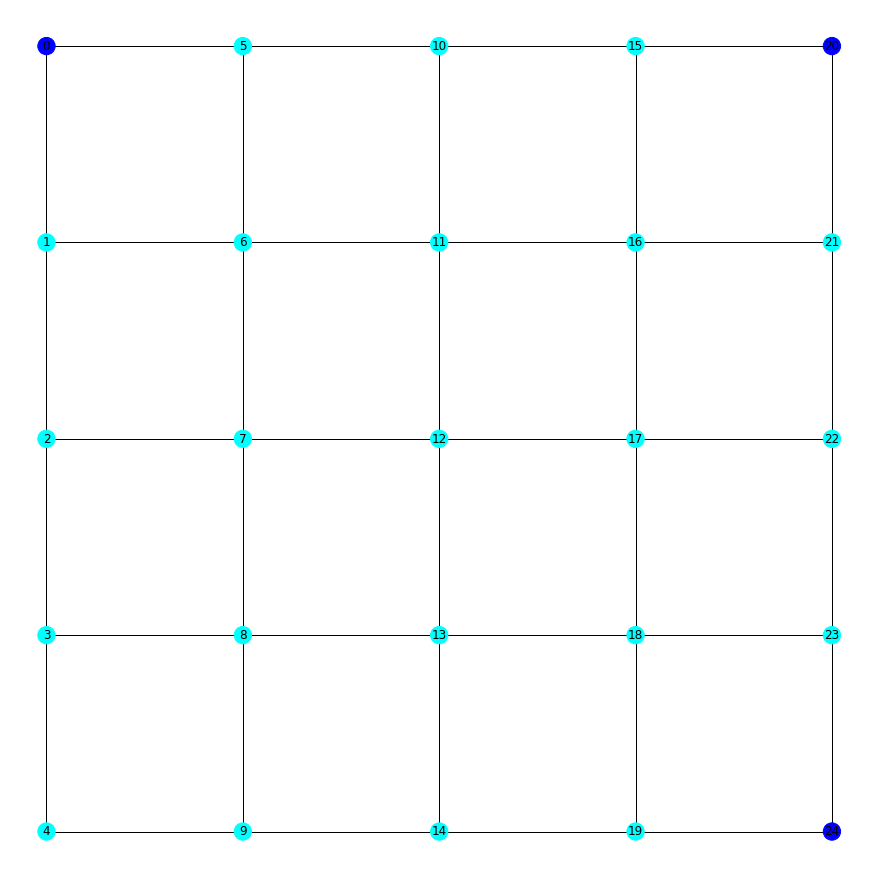

In [115]:
districts_keys = list(district.keys())
colorss = ["aqua","lawngreen","darkorange"]

color_map = {}
for node in list(G1.nodes):
    color_map[node] = "blue"
    for k in range(len(districts_keys)):
        if node in district[districts_keys[k]]:
            color_map[node] = colorss[k]

color_map = list(color_map.values())

plt.figure(3,figsize=(12,12))
nx.draw(G1,node_color=color_map, pos=grid_pos,with_labels = True)
plt.show()

In [102]:
#31/01/2022

#Without Updating Objective Function and Ordered V.2

#Check all nodes and pick the best
    
#Create a function that calculates the linear combination of infeasibility and dispersion for two selected districts.
def localsearch_grasp(district,centers_depots,combinations,adjacent_nodes,average_customers, average_demand,average_workload,shortest_paths_dict,llambda,delta,graph_input):    
   
    #Save value of best solution for comparisons. Onlly calculate the new one. Update when you find a better solution.
    #Update membership of each district. 
    
    
    def decision(x,y):

        y_customers = {}
        y_demand = {}
        y_workload = {}

        x_customers = {}
        x_demand = {}
        x_workload = {}

        for k in centers_depots:
            y_customers[k] = 0
            y_demand[k] = 0
            y_workload[k] = 0
            x_customers[k] = 0
            x_demand[k] = 0
            x_workload[k] = 0

    #Calculate the total for each  activity measure for each district allocation
        for k in centers_depots:
            for w in y[k]:
                y_customers[k] = y_customers[k] + graph_input.nodes[w]['n_customers']
                y_workload[k] = y_workload[k] + graph_input.nodes[w]['workload']
                y_demand[k] = y_demand[k] + graph_input.nodes[w]['demand']
            for w in x[k]:
                x_customers[k] = x_customers[k] + graph_input.nodes[w]['n_customers']
                x_workload[k] = x_workload[k] + graph_input.nodes[w]['workload']
                x_demand[k] = x_demand[k] + graph_input.nodes[w]['demand']






        weight_district_temp_f = (max(shortest_paths_dict[a][b] for i in y for a in y[i] for b in y[i]))
        #weight_district_temp_f = llambda*(max(get_furthest_nodes(graph_input.subgraph(y[centers_depots[i]]))['diameter'] for i in range(len(centers_depots))))

        weight_district_temp_g = 0
        for i in range(len(centers_depots)):

            ga1_temp = ((1/average_customers)*max(y_customers[centers_depots[i]]-(1+delta)*average_customers,(1-delta)*average_customers-y_customers[centers_depots[i]],0))
            ga2_temp = ((1/average_demand)*max(y_demand[centers_depots[i]]-(1+delta)*average_demand,(1-delta)*average_demand-y_demand[centers_depots[i]],0))
            ga3_temp = ((1/average_workload)*max(y_workload[centers_depots[i]]-(1+delta)*average_workload,(1-delta)*average_workload-y_workload[centers_depots[i]],0))

            weight_district_temp_g = weight_district_temp_g +(ga1_temp+ga2_temp+ga3_temp)

        weight_district_temp = llambda*weight_district_temp_f + (1-llambda)*weight_district_temp_g





        weight_district_best_f = (max(shortest_paths_dict[a][b] for i in x for a in x[i] for b in x[i]))
        weight_district_best_g = 0
        for i in range(len(centers_depots)):
            
            ga1_best = ((1/average_customers)*max(x_customers[centers_depots[i]]-(1+delta)*average_customers,(1-delta)*average_customers-x_customers[centers_depots[i]],0))
            ga2_best = ((1/average_demand)*max(x_demand[centers_depots[i]]-(1+delta)*average_demand,(1-delta)*average_demand-x_demand[centers_depots[i]],0))
            ga3_best = ((1/average_workload)*max(x_workload[centers_depots[i]]-(1+delta)*average_workload,(1-delta)*average_workload-x_workload[centers_depots[i]],0))

            weight_district_best_g = weight_district_best_g + (ga1_best+ga2_best+ga3_best)



        weight_district_best = llambda*weight_district_best_f + (1-llambda)*weight_district_best_g

    #Return True if the first district allocation is better

        if(weight_district_temp<weight_district_best):

            return True
        else:

            return False

    
    def merit_function(x):

        x_customers = {}
        x_demand = {}
        x_workload = {}

        for k in centers_depots:
            x_customers[k] = 0
            x_demand[k] = 0
            x_workload[k] = 0

    #Calculate the total for each  activity measure for each district allocation
        for k in centers_depots:
            for w in x[k]:
                x_customers[k] = x_customers[k] + graph_input.nodes[w]['n_customers']
                x_workload[k] = x_workload[k] + graph_input.nodes[w]['workload']
                x_demand[k] = x_demand[k] + graph_input.nodes[w]['demand']

        weight_district_best_f = (max(shortest_paths_dict[a][b] for i in x for a in x[i] for b in x[i]))

        weight_district_best_g = 0
        for i in range(len(centers_depots)):

            ga1_best = ((1/average_customers)*max(x_customers[centers_depots[i]]-(1+delta)*average_customers,(1-delta)*average_customers-x_customers[centers_depots[i]],0))
            ga2_best = ((1/average_demand)*max(x_demand[centers_depots[i]]-(1+delta)*average_demand,(1-delta)*average_demand-x_demand[centers_depots[i]],0))
            ga3_best = ((1/average_workload)*max(x_workload[centers_depots[i]]-(1+delta)*average_workload,(1-delta)*average_workload-x_workload[centers_depots[i]],0))

            weight_district_best_g = weight_district_best_g + (ga1_best+ga2_best+ga3_best)

        weight_district_best = llambda*weight_district_best_f + (1-llambda)*weight_district_best_g

    #Return value of merit function

        return weight_district_best
        
        
        
        
    def update_merit_function(input_solution,k,l,bu):
        x= cp.deepcopy(input_solution)
        x[l].remove(bu)
        x[k].append(bu)

        x_customers = {}
        x_demand = {}
        x_workload = {}

        for k in centers_depots:
            x_customers[k] = 0
            x_demand[k] = 0
            x_workload[k] = 0

        #Calculate the total for each  activity measure for each district allocation
        for k in centers_depots:
            for w in x[k]:
                x_customers[k] = x_customers[k] + graph_input.nodes[w]['n_customers']
                x_workload[k] = x_workload[k] + graph_input.nodes[w]['workload']
                x_demand[k] = x_demand[k] + graph_input.nodes[w]['demand']

        solution_infeasibility = 0
        for i in range(len(centers_depots)):

            ga1_best = ((1/average_customers)*max(x_customers[centers_depots[i]]-(1+delta)*average_customers,(1-delta)*average_customers-x_customers[centers_depots[i]],0))
            ga2_best = ((1/average_demand)*max(x_demand[centers_depots[i]]-(1+delta)*average_demand,(1-delta)*average_demand-x_demand[centers_depots[i]],0))
            ga3_best = ((1/average_workload)*max(x_workload[centers_depots[i]]-(1+delta)*average_workload,(1-delta)*average_workload-x_workload[centers_depots[i]],0))

            solution_infeasibility = solution_infeasibility + (ga1_best+ga2_best+ga3_best)
        

        solution_objective = (max(shortest_paths_dict[a][b] for i in x for a in x[i] for b in x[i]))


        weight_district_best = llambda*solution_objective + (1-llambda)*solution_infeasibility

        return weight_district_best
    
    
    district_trial2 = {}
    best_sol = {}

    
    #Copy the current district allocation
    for i in range(len(centers_depots)):
        district_trial2[centers_depots[i]] = district[centers_depots[i]][:]

    for i in range(len(centers_depots)):
        best_sol[centers_depots[i]] = district[centers_depots[i]][:]
        
    node_district_matching = {}
    for k in district:
        for i in district[k]:
            node_district_matching[i] = k


     
    moves = {}
    for depots in centers_depots:
        moves[depots] = []
        for nodes in node_district_matching:
            if node_district_matching[nodes] != depots:
                moves[depots].append(nodes)
    print(moves)

    depo_choices = {}
    for k in centers_depots:
        depo_choices[k] = [item for item in combinations
                if item[0] == k or item[1] == k]


    choose = random.choice(range(len(centers_depots)))

    k = centers_depots[choose]
    nmoves = 0
    p = len(centers_depots)
    local_optima = False

    number_of_moves = 0
    move_index = 0
    
            
    current_best_objective = merit_function(district)

    current_best_solution = cp.deepcopy(district)

    while(nmoves<1000 and local_optima==False):
        
        print("Repeating the for loop again")
        print(current_best_objective)
        improvement = False
        for k in centers_depots:
            print("Moving to next center",k)
            improvement = False
            for basic_unit in moves[k]:

                new_objective = update_merit_function(current_best_solution,k,node_district_matching[basic_unit],basic_unit)

                if new_objective < current_best_objective:
#                     print(k)
                    print("Better Objective found")
                    best_basic_unit = basic_unit
                    print(best_basic_unit)
                    current_best_objective = new_objective
                    improvement = True
            
            if improvement == True:
                current_best_solution[k].append(best_basic_unit)
                current_best_solution[node_district_matching[best_basic_unit]].remove(best_basic_unit)
                print("Succeeded in improving", current_best_objective)
                print("The best basic unit is", best_basic_unit)
                node_district_matching[best_basic_unit] = k
                moves[k].remove(best_basic_unit)
                moves[node_district_matching[best_basic_unit]].append(best_basic_unit)
                   


#             moves = {}
#             for depotss in centers_depots:
#                 moves[depotss] = []
#                 for nodes in node_district_matching:
#                     if node_district_matching[nodes] != depotss:
#                         moves[depotss].append(nodes)

        
        
        if improvement == True:    
            nmoves = nmoves+1
            local_optima = False
        else:
            local_optima = True
            print("Local Optimum Reached")
            
            
            
    best_obj = max(shortest_paths_dict[a][b] for i in current_best_solution for a in current_best_solution[i] for b in current_best_solution[i])
    
    best_sol_customers = {}
    best_sol_workload = {}
    best_sol_demand = {}
    
    for k in centers_depots:
        best_sol_customers[k]=0
        best_sol_demand[k]=0
        best_sol_workload[k]=0
        
    for k in centers_depots:
        for w in current_best_solution[k]:
            best_sol_customers[k] = best_sol_customers[k] + graph_input.nodes[w]['n_customers']
            best_sol_workload[k] = best_sol_workload[k] + graph_input.nodes[w]['workload']
            best_sol_demand[k] = best_sol_demand[k] + graph_input.nodes[w]['demand']
    
    local_infeasible = 0
    
    for i in range(len(centers_depots)):
        local_infeasible = local_infeasible + ((1/average_customers)*max(best_sol_customers[centers_depots[i]]-(1+delta)*average_customers,(1-delta)*average_customers-best_sol_customers[centers_depots[i]],0))+\
            ((1/average_demand)*max(best_sol_demand[centers_depots[i]]-(1+delta)*average_demand,(1-delta)*average_demand-best_sol_demand[centers_depots[i]],0))+\
                ((1/average_workload)*max(best_sol_workload[centers_depots[i]]-(1+delta)*average_workload,(1-delta)*average_workload-best_sol_workload[centers_depots[i]],0))

    #print(local_infeasible)
    
    return best_obj, local_infeasible, current_best_solution

In [116]:
#Three centers unequal distribution
local_obj, local_infeasible, local_sol = localsearch_grasp(district,centers_depots,combinations,adjacent_nodes,average_customers, average_demand,average_workload,shortest_paths_dict,0.3,0.05,G1)

{0: [], 20: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23], 24: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23]}
Repeating the for loop again
9.428999999999998
Moving to next center 0
Moving to next center 20
Better Objective found
1
Better Objective found
4
Succeeded in improving 8.624999999999998
The best basic unit is 4
Moving to next center 24
Better Objective found
1
Succeeded in improving 8.120999999999999
The best basic unit is 1
Repeating the for loop again
8.120999999999999
Moving to next center 0
Moving to next center 20
Better Objective found
2
Succeeded in improving 7.616999999999998
The best basic unit is 2
Moving to next center 24
Better Objective found
3
Succeeded in improving 7.112999999999999
The best basic unit is 3
Repeating the for loop again
7.112999999999999
Moving to next center 0
Moving to next center 20
Better Objective found
5
Succeeded in improving 6.608999999999999
The best basic unit is 5
Movi

In [103]:
#Three centers equal distribution
local_obj, local_infeasible, local_sol = localsearch_grasp(district,centers_depots,combinations,adjacent_nodes,average_customers, average_demand,average_workload,shortest_paths_dict,0.3,0.05,G1)

{0: [21, 15, 22, 17, 18, 13, 8, 14, 3, 9, 4, 19, 23], 20: [1, 5, 6, 11, 7, 2, 10, 12, 16, 19, 23], 24: [1, 5, 6, 11, 7, 2, 10, 12, 16, 21, 15, 22, 17, 18, 13, 8, 14, 3, 9, 4]}
Repeating the for loop again
4.220999999999998
Moving to next center 0
Better Objective found
4
Succeeded in improving 3.9209999999999985
The best basic unit is 4
Moving to next center 20
Moving to next center 24
Better Objective found
1
Succeeded in improving 3.416999999999999
The best basic unit is 1
Repeating the for loop again
3.416999999999999
Moving to next center 0
Moving to next center 20
Moving to next center 24
Better Objective found
5
Better Objective found
21
Succeeded in improving 2.912999999999999
The best basic unit is 21
Repeating the for loop again
2.912999999999999
Moving to next center 0
Moving to next center 20
Moving to next center 24
Better Objective found
5
Succeeded in improving 2.5979999999999994
The best basic unit is 5
Repeating the for loop again
2.5979999999999994
Moving to next cente

In [76]:
#Two centers unequal distribution
local_obj, local_infeasible, local_sol = localsearch_grasp(district,centers_depots,combinations,adjacent_nodes,average_customers, average_demand,average_workload,shortest_paths_dict,0.3,0.05,G1)

Repeating the for loop again
6.054
Moving to next center 0
Moving to next center 24
Better Objective found
1
Better Objective found
4
Succeeded in improving 5.418
The best basic unit is 4
Repeating the for loop again
5.418
Moving to next center 0
Moving to next center 24
Better Objective found
1
Succeeded in improving 5.082
The best basic unit is 1
Repeating the for loop again
5.082
Moving to next center 0
Moving to next center 24
Better Objective found
2
Succeeded in improving 4.746
The best basic unit is 2
Repeating the for loop again
4.746
Moving to next center 0
Moving to next center 24
Better Objective found
3
Succeeded in improving 4.41
The best basic unit is 3
Repeating the for loop again
4.41
Moving to next center 0
Moving to next center 24
Better Objective found
5
Better Objective found
9
Succeeded in improving 3.774
The best basic unit is 9
Repeating the for loop again
3.774
Moving to next center 0
Moving to next center 24
Better Objective found
5
Succeeded in improving 3.437

In [53]:
#Two centers equal distribution
local_obj, local_infeasible, local_sol = localsearch_grasp(district,centers_depots,combinations,adjacent_nodes,average_customers, average_demand,average_workload,shortest_paths_dict,0.3,0.05,G1)

Repeating the for loop again
2.73
Moving to next center 0
Moving to next center 24
Better Objective found
1
Better Objective found
3
Succeeded in improving 2.1149999999999998
The best basic unit is 3
Repeating the for loop again
2.1149999999999998
Moving to next center 0
Moving to next center 24
Better Objective found
1
Succeeded in improving 1.9469999999999998
The best basic unit is 1
Repeating the for loop again
1.9469999999999998
Moving to next center 0
Moving to next center 24
Local Optimum Reached


In [117]:
print(construction_infeasible)
print(construction_obj)

10.469999999999997
7


In [118]:
#Three centers unequal distribution
print(local_infeasible)
print(local_obj)

0.6600000000000001
5


In [105]:
#Three centers equal distribution
print(local_infeasible)
print(local_obj)

0.6600000000000001
6


In [55]:
#Two centers equal distribution
print(local_infeasible)
print(local_obj)

0.21000000000000002
6


In [77]:
#Two centers unequal distribution
print(local_infeasible)
print(local_obj)

0.21000000000000002
5


In [119]:
for k in centers_depots:
    for i in local_sol[k]:
        print(list(any(i in val for val in local_sol.values())))

[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[True, False, False]
[False, False, True]
[False, False, True]
[False, False, True]
[False, False, True]
[False, False, True]
[False, False, True]
[False, False, True]
[False, True, False]
[False, True, False]
[False, True, False]
[False, True, False]
[False, True, False]
[False, True, False]
[False, True, False]


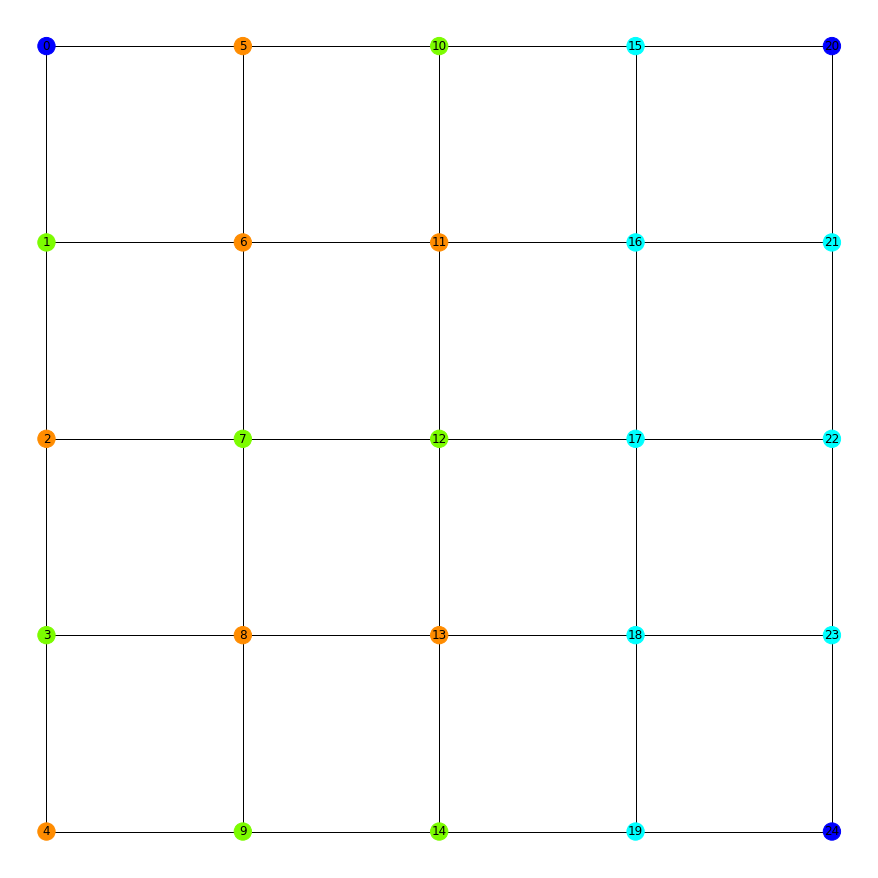

In [120]:
#Three centers equal distribution
districts_keys = list(local_sol.keys())
colorss = ["aqua","lawngreen","darkorange"]

color_map = {}
for node in list(G1.nodes):
    color_map[node] = "blue"
    for k in range(len(districts_keys)):
        if node in local_sol[districts_keys[k]]:
            color_map[node] = colorss[k]

color_map = list(color_map.values())

plt.figure(3,figsize=(12,12))
nx.draw(G1,node_color=color_map, pos=grid_pos,with_labels = True)
plt.show()

In [59]:
#Two centers equal distribution Input
two_centers_equal_distribution = district, centers_depots, combinations, adjacent_nodes, average_customers, average_demand,average_workload,shortest_paths_dict, construction_obj,construction_infeasible

In [81]:
#Two centers unequal distribution Input
two_centers_unequal_distribution = district, centers_depots, combinations, adjacent_nodes, average_customers, average_demand,average_workload,shortest_paths_dict, construction_obj,construction_infeasible

In [109]:
#Three centers equal distribution Input
three_centers_equal_distribution = district, centers_depots, combinations, adjacent_nodes, average_customers, average_demand,average_workload,shortest_paths_dict, construction_obj,construction_infeasible

In [121]:
#Three centers unequal distribution Input
three_centers_unequal_distribution = district, centers_depots, combinations, adjacent_nodes, average_customers, average_demand,average_workload,shortest_paths_dict, construction_obj,construction_infeasible